<font size=10><b> CUSTOMER SEGMENTATION FOR A UK-BASED ONLINE RETAIL </b></font>

# 1. INTRODUCTION

This notebook focuses on customer segmentation and sales transaction analysis for a UK-based e-commerce retail company. The analysis will concentrate on three key customer features: Recency, Frequency, and Monetary value.

The analysis aims to uncover valuable insights into customer behavior and transform the transactional data into a customer-centric dataset through feature engineering and clustering that will effectively aid in segmenting customers, enabling the business to determine appropriate marketing strategies and enhance the customer experience. Additionally, this analysis has the potential to significantly boost product sales, offering a promising outlook for the future.

Data Source: <a href= 'https://archive.ics.uci.edu/dataset/502/online+retail+ii'>UCI Machine Learning Repository | Online Retail II </a>

*This e-commerce dataset, made available by the UCI Machine Learning Repository, contains transactions made by approximately 4,300 customers from 2010-2011.

# 2. DATA WRANGLING

## 2.1 Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import re
import adjustText

#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
#%conda install openpyxl

## 2.2 Import Data

In [4]:
df = pd.read_excel('../data/raw/online_retail_II.xlsx', sheet_name = 'Year 2010-2011')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.shape

(541910, 8)

## 2.3 Define Functions

Define a custom logging function to track changes to the dataset.

In [6]:
ChangeLogs = {}
def log_changes(num, desc):
    '''Custom function to update ChangeLogs{} dictionary with the number of changed records and the description of the changes.
    Input:
        num - number of changed records to track
        desc - free text description of the changes
    Return: None
    '''
    idx = len(ChangeLogs)
    ChangeLogs[idx] = {'Number': num, 'Description': desc}

## 2.4 Data Wrangling

### 2.4.1 Inspect columns

In [7]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [8]:
df.rename(columns = {'Customer ID':'CustomerID'}, inplace=True)
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
rec_init = df.shape[0]

# Update Changes logs
log_changes(rec_init, 'Initial number of transaction records')

### 2.4.2 Inspect/Resolve inconsistencies in values

In [10]:
df.describe()

,Quantity,InvoiceDate,Price,CustomerID
count,541910.000000,541910,541910.000000,406830.000000
mean,9.552234,2011-07-04 13:35:22.342307584,4.611138,15287.684160
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.080957,NaN,96.759765,1713.603074


<font color='orange'>Inconsistency Found:</font> CustomerID count is not the same as that of the Quantity

**Resolve CustomerID count:**

Find ratio of null CustomerIDs

In [11]:
#Find ratio of Null Customer ID
rec_init = df.shape[0]

ratio_null_cust_id = round(len(df.loc[df['CustomerID'].isna()]) / len(df) * 100, 2)
print(f'Ratio of null customer IDs in the dataset: {ratio_null_cust_id} %')

Ratio of null customer IDs in the dataset: 24.93 %


- Approximately 25% of Customer ID is (null). 
- As the focus of the model is on Customer Segmentation, (null) Customer ID is of no value to the analysis; therefore, it is imperative to drop the (null) values.

In [12]:
# Drop null rows in Customer id
df = df.dropna(subset = ['CustomerID'])

# Update Changes logs
log_changes(-(rec_init - len(df)), 'Transaction records with null Customer IDs dropped')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406830 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406830 non-null  object        
 1   StockCode    406830 non-null  object        
 2   Description  406830 non-null  object        
 3   Quantity     406830 non-null  int64         
 4   InvoiceDate  406830 non-null  datetime64[ns]
 5   Price        406830 non-null  float64       
 6   CustomerID   406830 non-null  float64       
 7   Country      406830 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


<font color='orange'>Inconsitency Found:</font> Customer ID is of type float, and the decimals removed because according to the documentation: 

- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. 
The decimals in this column should be removed.

**Resolve CustomerID data type**

In [14]:
#Convert Customer ID from Float to int
df['CustomerID'] = df['CustomerID'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406830 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406830 non-null  object        
 1   StockCode    406830 non-null  object        
 2   Description  406830 non-null  object        
 3   Quantity     406830 non-null  int64         
 4   InvoiceDate  406830 non-null  datetime64[ns]
 5   Price        406830 non-null  float64       
 6   CustomerID   406830 non-null  int64         
 7   Country      406830 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.9+ MB


In [15]:
df.describe()

,Quantity,InvoiceDate,Price,CustomerID
count,406830.000000,406830,406830.000000,406830.000000
mean,12.061276,2011-07-10 16:31:30.127424512,3.460507,15287.684160
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693065,NaN,69.315080,1713.603074


<font color='orange'>Inconsistencies Found: </font> Negative values for Quantity and Price

**Resolve negative quantities and price**

In [16]:
#Inspect the negative quantities
df.loc[df['Quantity'] < 0].head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Compare negative values. Check if all these negative quantities are from Cancelled Invoices ( Invoices with "C" as a prefix )

In [17]:
#Compare negative values
df['Invoice'] = df['Invoice'].astype(str)
cancelled = df['Invoice'].str.contains(r'^[Cc]') 
negative = df['Quantity'] < 0
positive = df['Quantity'] >= 0

print(f'Negative quantities : {len(df.loc[df['Quantity'] < 0])}')
print(f'Cancelled Invoices: {len(df[cancelled])}')
print(f'Negative quantities with Cancelled invoices: {len(df[cancelled & ~positive])}' )
print(f'Positive quantities with Cancelled invoices: {len(df[cancelled & positive])}' )

Negative quantities : 8905
Cancelled Invoices: 8905
Negative quantities with Cancelled invoices: 8905
Positive quantities with Cancelled invoices: 0


Findings: All negative quantities are from Cancelled Invoices. \
Next Step: For this analysis, cancelled invoices will be dropped from the dataset

In [18]:
# Discard negative quantities ( this includes Cancelled invoices)
rec_init = len(df)
df = df[df['Quantity'] > 0]

log_changes(-(rec_init - len(df)), 'Transaction records with negative quantities or cancelled invoices dropped')

print(f'Number of non-negative quantities: {len(df)}')

Number of non-negative quantities: 397925


In [19]:
df['Quantity'].describe()

count    397925.000000
mean         13.021793
std         180.419984
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [20]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
dtype: int64

**Inspect/Resolve Invoices column**

Check Invoices column. Per the description:

- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 

In [21]:
#Check for incorrect invoices 
df['Invoice'] = df['Invoice'].astype(str)
df[df['Invoice'].str.match(r'^\d{5}$')].shape[0]

0

**Inspect/Resolve Stock Codes column**

Check Stock Codes. Per the description: 
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. 

In [22]:
#Stock Codes with non-numeric codes
df['StockCode'] = df['StockCode'].astype(str)
notnum = df[df['StockCode'].str.match(r'^\D')]
notnum['StockCode'].value_counts()
notnum.groupby(['StockCode', 'Description']).agg({'StockCode': 'count'})

,,StockCode
StockCode,Description,
BANK CHARGES,Bank Charges,12
C2,CARRIAGE,133
DOT,DOTCOM POSTAGE,16
M,Manual,290
PADS,PADS TO MATCH ALL CUSHIONS,4
POST,POSTAGE,1100


Inspect the other values of the non-conforming stock codes for inconsitencies or irregularities

In [23]:
#Stock Codes with numeric codes followed by Characters
alphanum = df[df['StockCode'].str.match(r'\d{5}\D')]
alphanum.groupby(['StockCode', 'Description']).agg({'StockCode': 'count'})

,,StockCode
StockCode,Description,
10123C,HEARTS WRAPPING TAPE,3
10124A,SPOTS ON RED BOOKCOVER TAPE,5
10124G,ARMY CAMO BOOKCOVER TAPE,4
15044A,PINK PAPER PARASOL,79
15044B,BLUE PAPER PARASOL,48
...,...,...
90214U,"LETTER ""U"" BLING KEY RING",1
90214V,"LETTER ""V"" BLING KEY RING",3
90214W,"LETTER ""W"" BLING KEY RING",1


Analyze both non-numeric and alphanumeric tables of stock codes

In [24]:
print(f'Stock Codes with Letters only: {len(notnum)}')
print(f'Stock Codes with Alphanumeric characters: {len(alphanum)}')
nonconf = pd.concat([notnum, alphanum])
nonconf

Stock Codes with Letters only: 1555
Stock Codes with Alphanumeric characters: 33251


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583,France
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662,Germany
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911,EIRE
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom
...,...,...,...,...,...,...,...,...
541778,581578,84997C,CHILDRENS CUTLERY POLKADOT BLUE,8,2011-12-09 12:16:00,4.15,12713,Germany
541809,581579,85099C,JUMBO BAG BAROQUE BLACK WHITE,10,2011-12-09 12:19:00,1.79,17581,United Kingdom
541841,581580,84993A,75 GREEN PETIT FOUR CASES,2,2011-12-09 12:20:00,0.42,12748,United Kingdom
541847,581580,85049A,TRADITIONAL CHRISTMAS RIBBONS,1,2011-12-09 12:20:00,1.25,12748,United Kingdom


Inspect the quantities with negative values in the new df

In [25]:
nonconf.loc[df['Quantity'] < 0].shape[0]

0

For this analysis, it is assumed that all the non-conforming stock codes are valid transactions done manually or automatically but outside the order placement process.\
This is because other columns for the non-conforming stock codes have no inconsistent values.

**Inspect/Resolve Invoice Date column**

Create a new month column (for later use)

In [26]:
df['Month'] = df['InvoiceDate'].dt.month
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12


Check month values

In [27]:
#Inspect no. of monthly transactions
df['Month'].value_counts().sort_index()

Month
1     21232
2     19928
3     27177
4     22644
5     28322
6     27185
7     26827
8     27013
9     40030
10    49557
11    64545
12    43465
Name: count, dtype: int64

**Inspect/Resolve Duplicate records**

In [28]:
print('Duplicates rows detected?:', df.duplicated().any())
print('No. of duplicates to be dropped ', len(df[df.duplicated()]))
rec_init = len(df)

df = df.drop_duplicates()
df

log_changes(-(rec_init-len(df)), 'Duplicate transaction records dropped')

Duplicates rows detected?: True
No. of duplicates to be dropped  5192


In [29]:
df.shape

(392733, 9)

# 3. EXPLORATORY DATA ANALYSIS

## 3.1 Import Additional libraries for EDA

In [30]:
# !pip install adjustText

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns 
import calendar as cal
from adjustText import adjust_text

## 3.2 Explore Data

In [32]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392733 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      392733 non-null  object        
 1   StockCode    392733 non-null  object        
 2   Description  392733 non-null  object        
 3   Quantity     392733 non-null  int64         
 4   InvoiceDate  392733 non-null  datetime64[ns]
 5   Price        392733 non-null  float64       
 6   CustomerID   392733 non-null  int64         
 7   Country      392733 non-null  object        
 8   Month        392733 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(4)
memory usage: 28.5+ MB


**Dealing with Price**

In [34]:
df.describe()

,Quantity,InvoiceDate,Price,CustomerID,Month
count,392733.000000,392733,392733.000000,392733.000000,392733.000000
mean,13.153687,2011-07-10 19:15:57.956932608,3.125633,15287.728182,7.601946
min,1.000000,2010-12-01 08:26:00,0.000000,12346.000000,1.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13955.000000,5.000000
50%,6.000000,2011-07-31 12:02:00,1.950000,15150.000000,8.000000
75%,12.000000,2011-10-20 12:53:00,3.750000,16791.000000,11.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,12.000000
std,181.588189,NaN,22.240710,1713.570644,3.415026


Minimum in price is 0.\
Remove the rows from the dataset as it will impact the monetary component in the analysis.

In [35]:
df = df.query('Price > 0')

print('0 price in the dataset after changes: ',  np.sum(df.Price <= 0))

df['Price'].describe()

0 price in the dataset after changes:  0


count    392693.000000
mean          3.125952
std          22.241820
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: Price, dtype: float64

**Inspect Invoice Date**

Transform Date Column Type and check range.

In [36]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.normalize()

print(min(df['InvoiceDate']), max(df['InvoiceDate']))

2010-12-01 00:00:00 2011-12-09 00:00:00


Filter dataset to only include dates later than 2011-01-01

In [37]:
df  = df[df['InvoiceDate'] >= '2011-01-01']

log_changes(df.shape[0], 'Records under 2011 timeframe')

**Create column - Sales**

In [38]:
#Create Sales column (Useful for RFM Analysis later)
df['Sales'] = df.Quantity * df.Price
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,Sales
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04,1.95,13313,United Kingdom,1,19.5
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04,0.42,13313,United Kingdom,1,10.5
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04,0.42,13313,United Kingdom,1,10.5
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04,2.10,13313,United Kingdom,1,10.5
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04,1.25,13313,United Kingdom,1,12.5


In [39]:
df.shape

(367023, 10)

## 3.3 Summary Statistics

In [40]:
df.describe( include='all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Month,Sales
count,367023,367023,367023,367023.000000,367023,367023.000000,367023.000000,367023,367023.000000,367023.000000
unique,17132,3596,3784,NaN,NaN,NaN,NaN,36,NaN,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN,NaN
freq,542,1816,1809,NaN,NaN,NaN,NaN,325745,NaN,NaN
mean,NaN,NaN,NaN,13.189786,2011-07-25 03:02:48.816668416,3.124763,15271.672315,NaN,7.294273,22.660172
min,NaN,NaN,NaN,1.000000,2011-01-04 00:00:00,0.001000,12346.000000,NaN,1.000000,0.001000
25%,NaN,NaN,NaN,2.000000,2011-05-04 00:00:00,1.250000,13924.000000,NaN,5.000000,4.950000
50%,NaN,NaN,NaN,6.000000,2011-08-15 00:00:00,1.850000,15116.000000,NaN,8.000000,12.480000
75%,NaN,NaN,NaN,12.000000,2011-10-25 00:00:00,3.750000,16771.000000,NaN,10.000000,19.800000
max,NaN,NaN,NaN,80995.000000,2011-12-09 00:00:00,8142.750000,18287.000000,NaN,12.000000,168469.600000


**Evaluate Categorical Variables**

In [41]:

print('Unique Invoices: ', df.Invoice.nunique())
print('Unique Countries: ', df.Country.nunique())
print('Unique StockCodes: ', df.StockCode.nunique())
print('Unique Customer IDs: ', df.CustomerID.nunique())

Unique Invoices:  17132
Unique Countries:  36
Unique StockCodes:  3596
Unique Customer IDs:  4219


**Extract Monthly Data**

Montly Sales

In [42]:
np.arange(0,100000, 10000)

array([    0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000,
       90000])

In [43]:
ms = df.groupby('Month')['Sales'].agg(['mean', 'median', 'sum']).reset_index()
ms

,Month,mean,median,sum
0,1,27.067911,12.60,568101.310
1,2,22.637010,13.20,446084.920
2,3,22.109481,12.75,594081.760
3,4,20.878809,12.75,468374.331
4,5,24.128349,15.00,677355.150
5,6,24.513335,12.60,660046.050
6,7,22.534345,12.50,598962.901
7,8,24.040726,13.91,644051.040
8,9,23.965570,13.52,950690.202
9,10,21.225226,10.50,1035642.450


Top 5 items sold per month

In [44]:
mtops = df.groupby(['Month', 'StockCode']).agg(TotalSold = ('Quantity', 'sum'))\
    .TotalSold.groupby('Month', group_keys=False).nlargest(5)
mtops = pd.DataFrame(mtops).reset_index('StockCode').rename(columns={'':'TotalSold'})
mtops.reset_index(inplace=True)

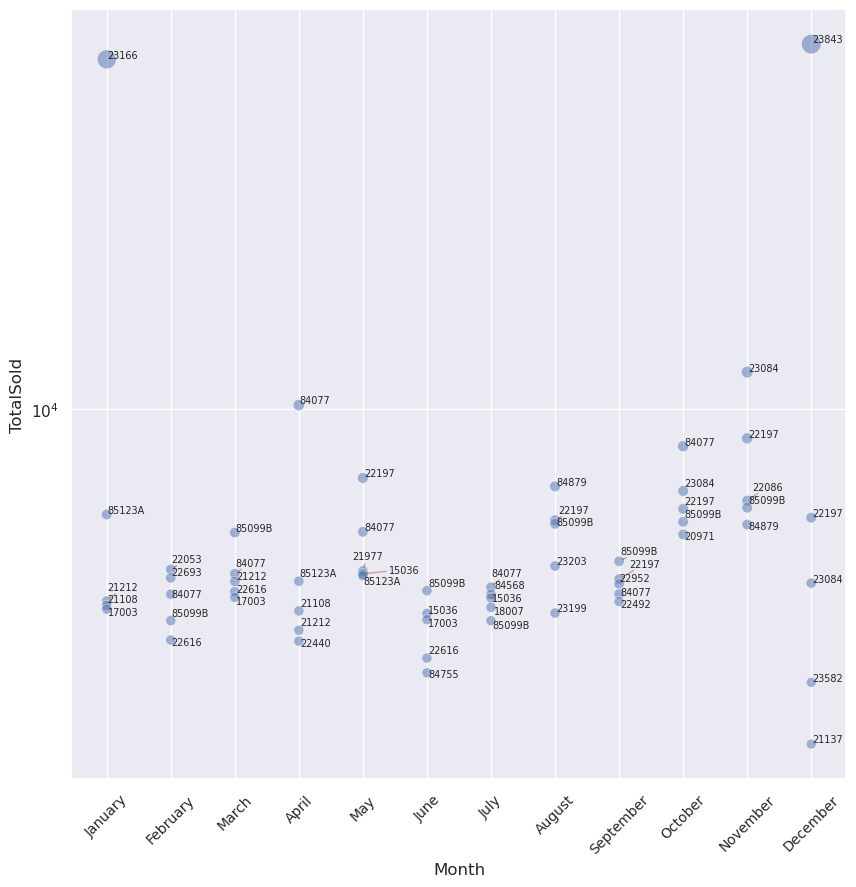

In [45]:
# import matplotlib.ticker as mticker

sns.set_theme('notebook')

plt.figure(figsize=(10,10))
scatter = sns.scatterplot(data=mtops, x='Month', y='TotalSold', alpha=0.5, size='TotalSold', sizes=(50,200))
scatter.set_xticks(np.arange(1,13, 1)) 
scatter.set_xticklabels([cal.month_name[i] for i in np.arange(1,13, 1)], rotation=45, size=10)
scatter.set_yscale('log')
scatter.legend_.remove()


plt.rcParams.update({'font.size': 7})
texts = []
for x, y, text in zip(mtops.iloc[:, 0], mtops.iloc[:, 2], mtops.iloc[:, 1]):
    texts.append(scatter.text(x, y, text))
adjust_text(texts, force_text=0.05, arrowprops=dict(arrowstyle="-|>",
                                                    color='r', alpha=0.5, ), prevent_crossings=True)
plt.tight_layout
plt.show()

Monthly Quantities

In [185]:
mq = df.groupby('Month')['Quantity'].agg('sum')
mq = mq.reset_index()
mq

,Month,Quantity
0,1,348473
1,2,265027
2,3,347582
3,4,291366
4,5,372864
5,6,363014
6,7,367360
7,8,397373
8,9,543652
9,10,591543


In [280]:
#TOP ITEMS PER MONTH

**Visualize monthly sales and sold items**

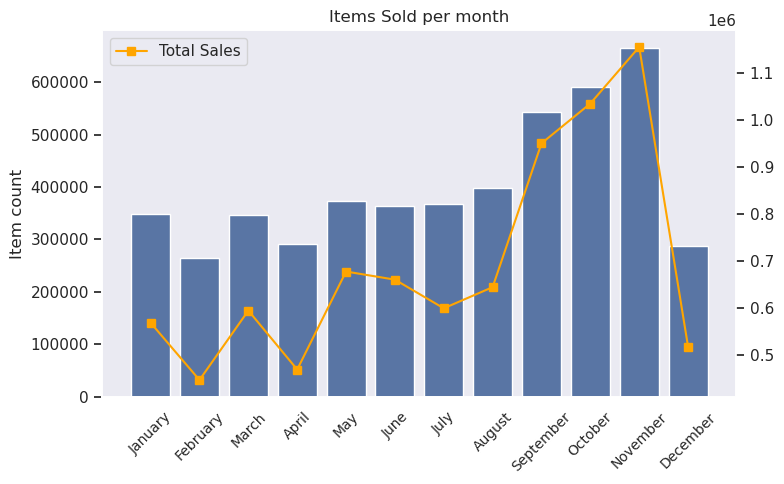

In [279]:
sns.set_style('dark')
plt.figure(figsize=(8,5))

ax = sns.barplot(data=mq, x=mq.Month, y=mq.Quantity)
ax.set_title('Items Sold per month')
ax.set_xticklabels([cal.month_name[i] for i in np.arange(1,13, 1)], rotation=45, size=10)
ax.set_xlabel('')
ax.set_ylabel('Item count')

tx = ax.twinx()
tx.plot(ms['sum'], label='Total Sales', color='orange', marker='s',)

plt.legend()
plt.tight_layout()

Monthly Sales

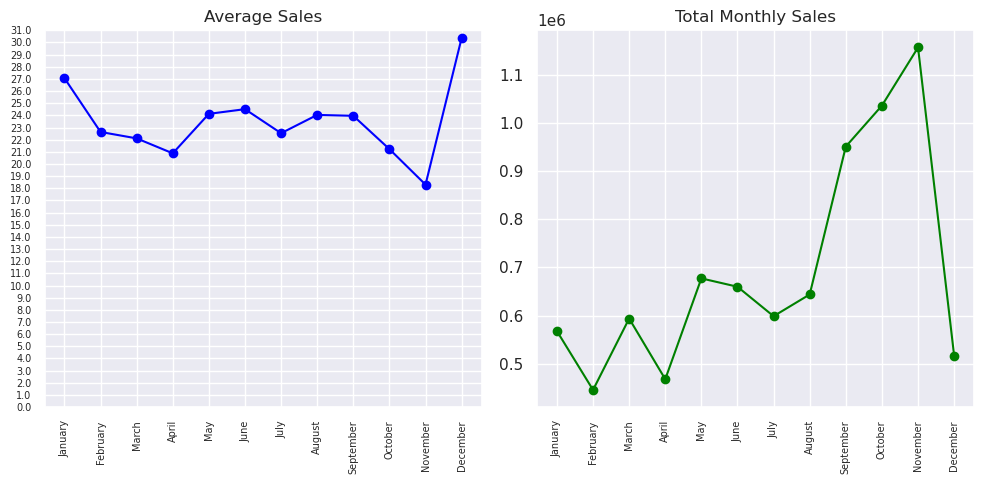

In [231]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.2, hspace=0.3)


ax[0].plot(ms['mean'], label='Average Sales', color='blue', marker='o')
ax[0].set_xticks(ms.Month.values - 1) 
ax[0].set_yticks(np.arange(0, ms['mean'].max() + 1, 1)) 
# ax[0].yaxis.set_tick_params(labelsize=7, )
ax[0].set_xticklabels([cal.month_name[i] for i in ms.Month.values], size=7) 
ax[0].set_yticklabels(np.arange(0, ms['mean'].max() + 1, 1), fontsize=7)
ax[0].tick_params('x', labelrotation=90)
ax[0].set_title('Average Sales')


ax[1].plot(ms['sum'], label='Total Sales', color='green', marker='o')
ax[1].set_xticks(ms.Month.values - 1) 
ax[1].set_xticklabels([cal.month_name[i] for i in ms.Month.values], size=7) 
ax[1].tick_params('x', labelrotation=90)
ax[1].set_title('Total Monthly Sales')

plt.tight_layout()
plt.show()

In [201]:
print(min(df[df.Month == 11]['Sales'] ))
print(max(df[df.Month == 11]['Sales'] ))

0.06
3651.6


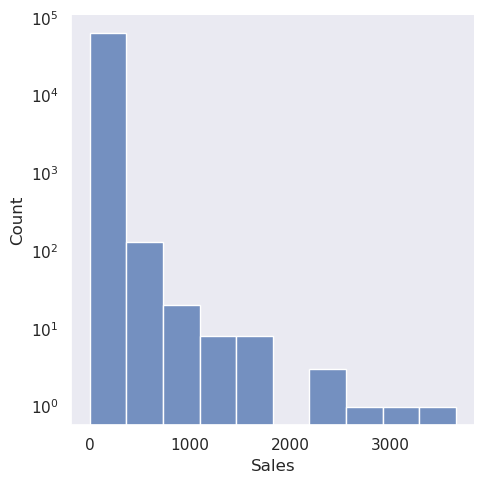

In [259]:
sns.displot(df[df.Month == 11]['Sales'], kind='hist', bins=10 )
plt.yscale('log')#distplot(bins=100, =True)
plt.tight_layout()

Investigate the steep decline in sales for the month of December (which is unusual for the amount of Sales during this time of the year)

In [44]:
print('% of December Transactions: ', round(len(df.query('Month == 12')) * 100 / len(df), 2), '%')
print('Latest December Transaction: ', df.query('Month == 12')['InvoiceDate'].max() )

% of December Transactions:  4.64 %
Latest December Transaction:  2011-12-09 00:00:00


Most recent invoice was recorded only until Dec 9. \
The transactions in the dataset appear incomplete as it did not capture the whole transactions for the month of December 2011.

### 3.4 Transform data into Transactions per Customer

Create a new Recency column and calculate the date difference.

In [45]:
recent_invdt = df['InvoiceDate'].max() #Ideally, should be the latest day of invoice (near today's date)

df_percust = df.groupby('CustomerID', as_index=False) \
    .agg( 
        LastPurchaseDate = ('InvoiceDate', 'max'),
        Frequency = ('Invoice', 'nunique'),
        Monetary = ('Sales', 'sum'))

df_percust['Recency'] = (recent_invdt - df_percust['LastPurchaseDate']).dt.days
df_percust.head()


log_changes(df_percust.shape[0], 'Number of Customers with RFM records')

### 3.5. Plot distribution of Recency, Frequency, and Monetary per Customer

Histogram

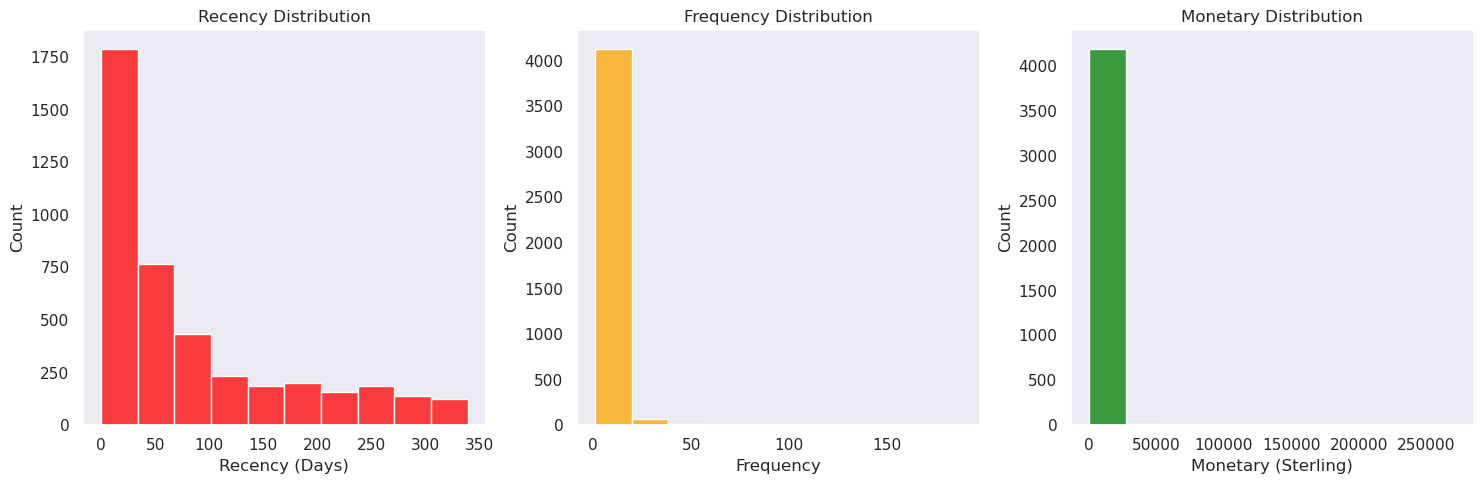

In [46]:
sns.set_theme(style='dark')
fig, ax= plt.subplots(1,3, figsize=(15,5))

#Recency
sns.histplot(df_percust.Recency, bins=10, color='red', ax=ax[0])
# ax[0].grid(False)
ax[0].set_xlabel('Recency (Days)')
ax[0].set_title('Recency Distribution')

#Frequency
sns.histplot(df_percust.Frequency, bins=10, color='orange', ax=ax[1])
# ax[1].hist(df_percust.Frequency, bins=3, color='orange')
ax[1].set_xlabel('Frequency')
ax[1].set_title('Frequency Distribution')

#Monetary
sns.histplot(df_percust.Monetary, bins=10, color='green', ax=ax[2])
ax[2].set_xlabel('Monetary (Sterling)')
ax[2].set_title('Monetary Distribution')

plt.tight_layout()

Box plot

Text(0.5, 1.0, 'Monetary Boxplot')

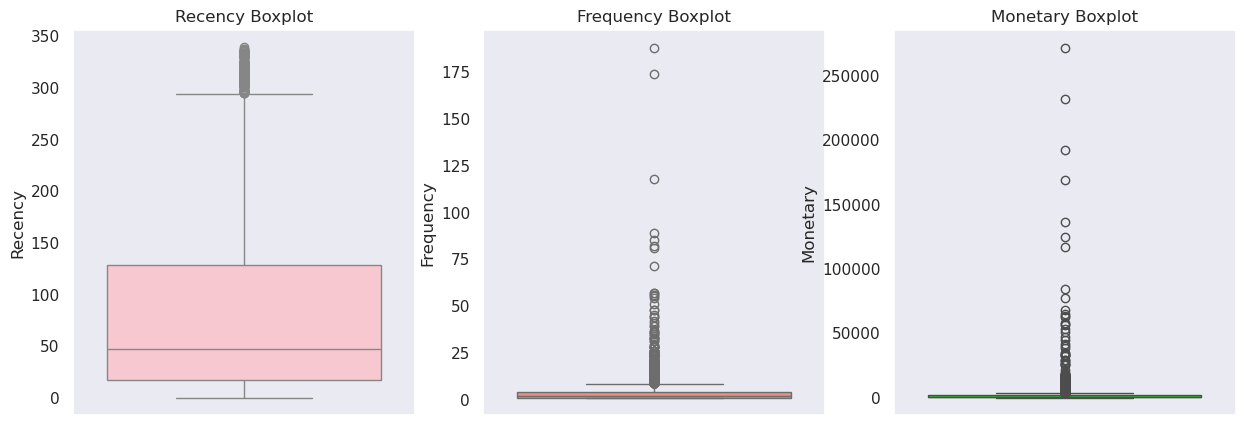

In [47]:
fig, ax= plt.subplots(1,3, figsize=(15,5))

#Recency
sns.boxplot(data=df_percust.Recency, color='pink', ax=ax[0])
ax[0].set_title('Recency Boxplot')

#Frequency
sns.boxplot(data=df_percust.Frequency, color='salmon', ax=ax[1])
ax[1].set_title('Frequency Boxplot')

#Monetary
sns.boxplot(data=df_percust.Monetary, color='lime', ax=ax[2])
ax[2].set_title('Monetary Boxplot')

There are many outliers as can be seen from the R/F/M boxplots. \
A separate analysis should be performed as they represent extreme behaviours by the customers, such as very big spending and very frequent purchases.

# 4. PRE-PROCESSING AND FEATURE ENGINEERING

The later part of EDA activities indicates the presence of outliers. \
Since the focus of this project is on clustering, only the non-outliers will be processed by the model. 

It is emparative to analyze the outliers as they represent extreme behaviours by the customers, such as high spending and very frequent purchases; therefore, that step will be performed after the modeling.


## 4.1 Outlier detection and handling 

Separate outliers (big spenders and frequent spenders) from the rest of the data 

In [48]:
#Create a function for extracting outliers
def outliers(p_df, col):
    '''Function for computing outliers. 
    Input: (1)Dataframe, (2)column name.
    Return: rows of outliers in a dataframe'''

    q1 = p_df[col].quantile(0.25)
    q3 = p_df[col].quantile(0.75)
    iqr = q3 - q1
    outlier = p_df[( p_df[col] > (q3 + 1.5*iqr)) | (p_df[col] < (q1 - 1.5*iqr)) ]
    return outlier

In [49]:
#Big spenders: Monetaty outliers
df_m_outliers = outliers(df_percust, 'Monetary')

#Frequent buyers: Frequency outliers
df_f_outliers = outliers(df_percust, 'Frequency')

print('Monetary outliers: ', df_m_outliers.shape[0])
print('Frequency outliers: ', df_f_outliers.shape[0])

Monetary outliers:  402
Frequency outliers:  412


In [50]:
df_percust.shape

log_changes(df_m_outliers.shape[0], 'Number of Monetary outliers')
log_changes(df_f_outliers.shape[0], 'Number of Frequency outliers')

Separate and visualize non-outliers. \
First, back up df.

In [51]:
df_eda = df.copy(deep=True)
df_eda.shape

(367023, 10)

Next, subset the non-outliers for subsequent processing.

In [52]:
df = df_percust[ (~df_percust.index.isin(df_m_outliers.index)) &  (~df_percust.index.isin(df_m_outliers.index)) ]
print(f'No. of Non-outlier records:  {df.shape[0]} from {df_percust.shape[0]} or {round(df.shape[0]*100/df_percust.shape[0],2)} %' )

log_changes(df.shape[0], 'Number of Non outliers in Customer RFM records for modeling')

No. of Non-outlier records:  3817 from 4219 or 90.47 %


Visualize non-outliers based on Recency, Frequency, and Monetary

<Axes: ylabel='Monetary'>

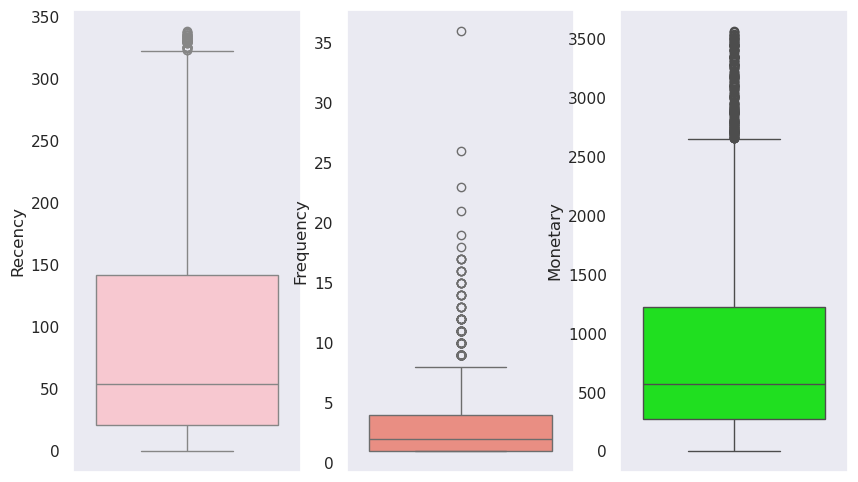

In [53]:
fig, ax = plt.subplots(1,3, figsize=(10,6))

sns.boxplot(data=df.Recency, color='pink', ax=ax[0])
sns.boxplot(data=df.Frequency, color='salmon', ax=ax[1])
sns.boxplot(data=df.Monetary, color='lime', ax=ax[2])

3D scatterplot visualization for Recency,Frequency, and Monetary.

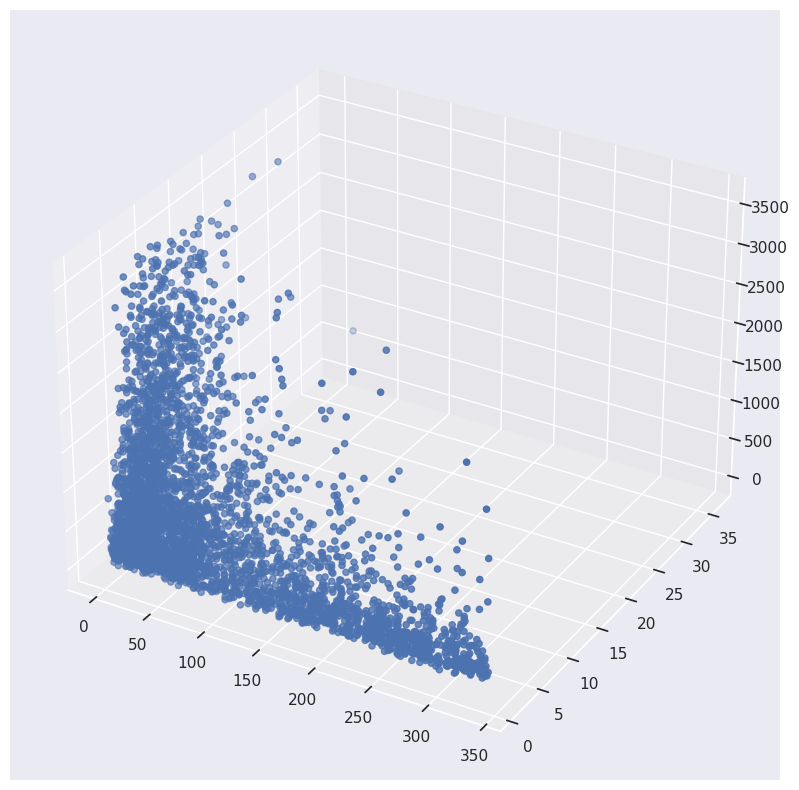

In [54]:
sns.set_style ("darkgrid")
plt.figure (figsize = (10,10))
seaborn_plt = plt.axes (projection='3d')
seaborn_plt.scatter3D(df.Recency, df.Frequency, df.Monetary)

## 4.2 Scaling

Prepare data for scaling. The columns of interest are recency, frequency, and monetary, so all other columnns the dataset are be dropped.


In [55]:
df = df.drop('LastPurchaseDate', axis=1)
df = df.set_index('CustomerID')

#Back up the indices and columns
rfm_idx = df.index
rfm_cols = df.columns

df.head()

,Frequency,Monetary,Recency
CustomerID,,,
12348,3,904.44,75
12349,1,1757.55,18
12350,1,334.40,310
12352,8,2506.04,36
12353,1,89.00,204


Scale/Standarize the data

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df)

df_scaled = pd.DataFrame(rfm_scaled, columns=rfm_cols, index=rfm_idx)
df_scaled

log_changes(df_scaled.shape[0], 'Number of scaled Customer RFM records for modeling')

Check if normalized. Mean ~ 0 and Standard Deviation ~ 1.

In [57]:
print(df_scaled.mean())
print('\n', df_scaled.std(ddof=0))

Frequency    4.560728e-17
Monetary    -1.489217e-17
Recency     -2.792282e-17
dtype: float64

 Frequency    1.0
Monetary     1.0
Recency      1.0
dtype: float64


Visualize the distribution after standardization

In [58]:
# fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,6), squeeze=False)

# for idx, col in enumerate(df.columns):

#     axes[0][idx].hist(df[col], bins=8, color='green')
#     axes[0][idx].set_xlabel(col + ' Value')
#     axes[0][idx].set_ylabel('Count')
#     # plt.axvline(df_rfm_col[col].mean(), size)
#     axes[0][idx].set_title( col + ' Distribution')

# plt.show()  

After standardization:

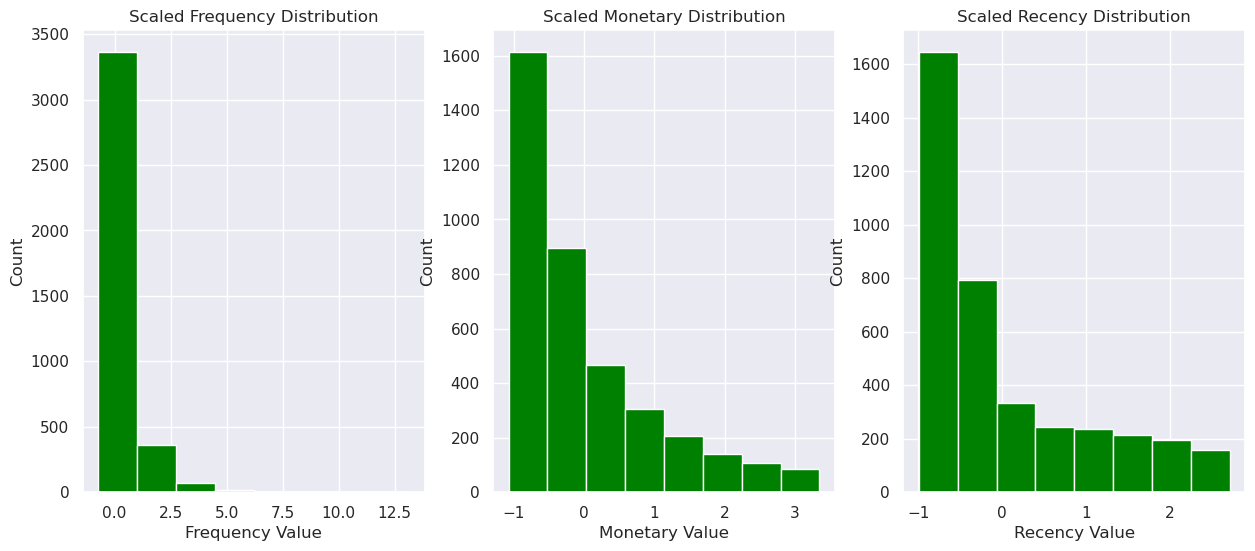

In [59]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(15,6), squeeze=False)

for idx, col in enumerate(rfm_cols):

    axes[0][idx].hist(df_scaled[col], bins=8, color='green')
    axes[0][idx].set_xlabel(col + ' Value')
    axes[0][idx].set_ylabel('Count')
    # plt.axvline(df_rfm_col[col].mean(), size)
    axes[0][idx].set_title('Scaled ' + col + ' Distribution')

plt.show()    

Show logs

In [60]:
df_logs = pd.DataFrame(ChangeLogs).T
df_logs

,Number,Description
0,541910,Initial number of transaction records
1,-135080,Transaction records with null Customer IDs dro...
2,-8905,Transaction records with negative quantities o...
3,-5192,Duplicate transaction records dropped
4,367023,Records under 2011 timeframe
5,4219,Number of Customers with RFM records
6,402,Number of Monetary outliers
7,412,Number of Frequency outliers
8,3817,Number of Non outliers in Customer RFM records...
9,3817,Number of scaled Customer RFM records for mode...


# 5. MODELING

## 5.1 Model Prerequisites

Preferred clustering algorithms to be tested:
- KMeans Clustering
- Agglomerative Clustering
- DBSCAN

To determine the parameters for DBSCAN, it's essential to determine the two hyperparameters in DBSCAN (MinPts and 𝜀𝜀 ) that need to be optimized to yield good clustering results.\
Finding a good combination of MinPts and 𝜀𝜀 can be problematic if the density differences in the dataset are relatively large. \
A general rule of thumb is to set MinPts >= D+1, where D is the number of dimensions in the dataset. For most cases, a minimum value of MinPts = 3 is recommended.\
Create a k-distance graph to serve as a guide in selecting the appropriate epsilon value.\
Steps:
1. Calculate the distance to the k-th nearest neighbor for each point.
2. Sort and plot the distance and use the elbow method to choose the epsilon. 

For the hyperparameter optimization, a range of values near the elbow point will be used.

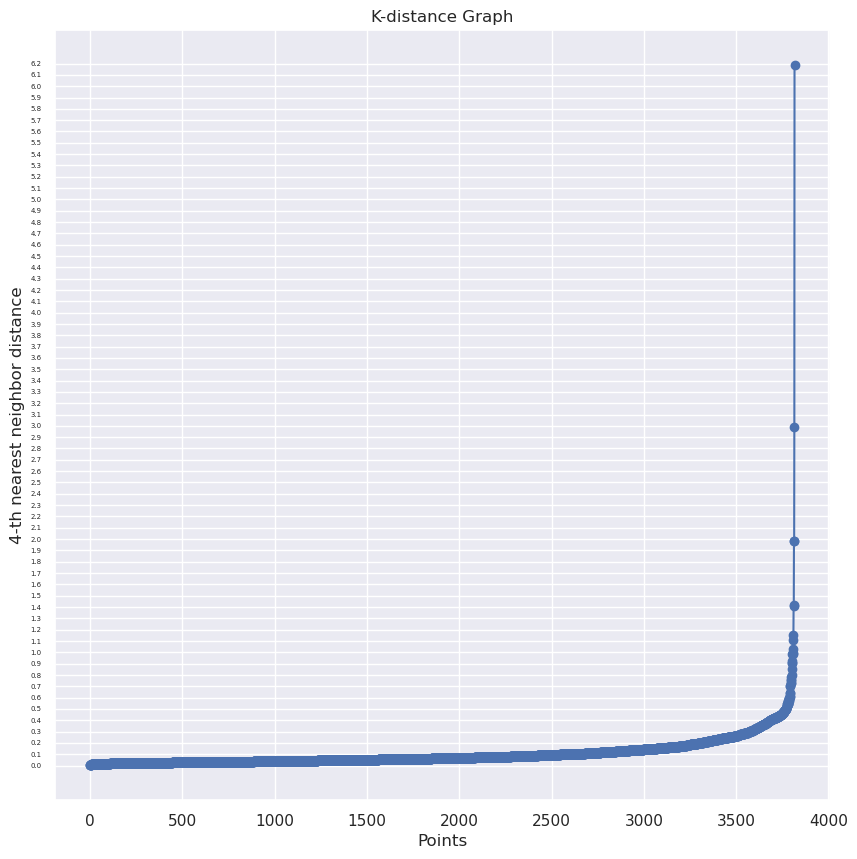

In [61]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

test_k = 4
X_scaled = df_scaled.to_numpy()
mdl_nn = NearestNeighbors(n_neighbors=test_k)
mdl_nn.fit(X_scaled)

distances, indices = mdl_nn.kneighbors(X_scaled)
distances = np.sort(distances[:, test_k-1])

plt.figure(figsize=(10,10))
plt.plot(distances, '-o')

plt.xlabel('Points')
plt.ylabel(f'{test_k}-th nearest neighbor distance')
plt.yticks(np.arange(0, max(distances)+0.1, 0.1), fontsize=5)
plt.title('K-distance Graph')
plt.show()

The estimated elbow point is between 0.1 - 0.2 

**Import libraries**

In [62]:
# !conda install hyperopt

In [63]:
from matplotlib import colormaps
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.pipeline import Pipeline
from hyperopt import hp, tpe, rand, space_eval, fmin, Trials, STATUS_OK

#Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import time

Set the random seed

In [64]:
random_seed = 177
np.random.seed(random_seed)
np.random.default_rng(random_seed)

Generator(PCG64) at 0x7FB39044D540

In [65]:
X = df.to_numpy()
X_scaled = df_scaled.to_numpy()

In [66]:
X.shape, X_scaled.shape

((3817, 3), (3817, 3))

## 5.2 Hyperparameter Tuning

**Define model parameters and spaces**

In [67]:
#Dictionary for model paramaters:

models = {
    'KMeans': {
        'model': KMeans(random_state=random_seed),
        'params': {
            'cluster__n_clusters': np.arange(2,11,1),
            'cluster__init' : ['random', 'k-means++'],
            'cluster__n_init' :  np.arange(5,11,5),
            'cluster__max_iter': np.arange(100,1100,100),
            'cluster__tol': [0.0001, 0.001, 0.01, 0.1],
            'cluster__algorithm' : ['lloyd', 'elkan']
        }
    },

    'Agglomerative': {
        'model': AgglomerativeClustering(),
        'params': {
            'cluster__n_clusters': np.arange(2,11,1),
            'cluster__metric' : [ 'euclidean', 'l1', 'l2', 'manhattan', 'cosine'], 
            'cluster__linkage': ['complete', 'average', 'single'],
            'cluster__compute_distances' : [True, False]
        }
    },

    'DBSCAN': {
        'model': DBSCAN(), 
        'params': {
            'cluster__eps': np.arange(0.1, 0.2, 0.01),
            'cluster__min_samples' : np.arange(4,11,1), 
            'cluster__metric': ['euclidean']
        }
    }
}

In [68]:
#Spaces for KMeans required for SMBO using hyperopt

km_space = {
    'n_clusters': hp.uniformint('n_clusters', 2, 10, q=2),
    'init' : hp.choice('init', ['random', 'k-means++']),
    'n_init' :hp.uniformint('n_init', 5,10, q=5),
    'max_iter': hp.uniformint('max_iter', 100, 1000, q=100),
    'tol': hp.choice('tol', [0.0001, 0.001, 0.01, 0.1]),
    'algorithm' : hp.choice('algorithm', ['lloyd', 'elkan'])
}

**Functions for Cross-Validation**

In [69]:
# Custom function for Randomized Search and Grid Search:

def f_hp_optimization(desiredcv, x_data, pipe, params, njobs, f_scoring, fold):
    '''Custom function that runs GridSearchCV and RandomSearch CV using the estimator and parameter of choice.
    
    Input: 
        desiredcv - CrossValidation model (sklearn.model_selection object, i.e. RandomizedSearchCV | GridSearchCV)
        x_data - working dataset (numpy.ndarray)
        pipe - defined pipeline( Pipeline object )
        params - a dictionary of the model's parameters (dict)
        n_jobs - no of jobs (int)
        f_scoring - scoring metric or a custom function for clustering algorithms  (func)
        fold - cross-validation number of folds (int)
    Return:
        Cross-validation object fitted with data (sklearn.model_selection._search.*Randomized\Grid* SearchCV object)
    '''

    cv = None
    time_start = time.time()

    np.random.seed(random_seed)
    np.random.default_rng(random_seed)
    
    if desiredcv == GridSearchCV:
        cv = GridSearchCV(pipe, param_grid=params, n_jobs = njobs, scoring=f_scoring, cv=fold)  
    elif desiredcv == RandomizedSearchCV:
        cv = RandomizedSearchCV(pipe,param_distributions = params, n_jobs = njobs,  scoring=f_scoring, cv=fold, random_state=random_seed)  

    if cv!= None:
        cv.fit(x_data)
        
        time_end = time.time()
        runtime = time_end - time_start
        
        print(f'+++ {pipe['cluster']} {desiredcv} results: +++')
        print('Model Total running time: ', runtime)
        print("Best hyperparameters: ", cv.best_params_)
        print('Score: ', cv.best_score_)
        
        print('\n')

    return cv

In [70]:
# Custom scoring functions for GridSearchCV and RandomizedSearchCV

def f_silhouette_score(pipex, X):
    return silhouette_score(X, pipex.fit_predict(X))

def f_inertia_score(pipex, X):
    return pipex['cluster'].inertia_

**Functions for Bayesian Search**

In [71]:
# Objective functions for Bayesian Search using SMBO technique in ***hyperopt*** package for KMeans

def km_f_objective(space):
    
    np.random.seed(random_seed)
    np.random.default_rng(random_seed)

    kmeans = KMeans(n_clusters = space['n_clusters'], 
                    random_state=random_seed, 
                    tol= space['tol'], 
                    n_init= space['n_init'], 
                    max_iter= space['max_iter'], 
                    init= space['init'],
                    algorithm= space['algorithm']
                    )

    clusterlabels = kmeans.fit_predict(X_scaled)
    score = kmeans.inertia_
     
    return {'loss' : -(score), 'status': STATUS_OK }

***Scoring functions for Agglomerative Clustering and DBSCAN:***

Both Agglomerative clustering and DBSCAN have no explicit loss function. Agglomerative Clustering use distance metric, and DBSCAN does not necessarily divide data into spherical clusters, so inertia is not a good metric for evaluating DBSCAN and Agglomerative Clustering models.\
In the next section, Silhouette scores will be computed for both algorithms in CV. SMBO will be skipped for both due to the lack of loss function on both algorithms

**Nested Cross-Validation**

This step will use nested cross-validation approach to determine the optimal parameters per clustering algorithm. In summary, this step will: 
1. Cycle through the 3 chosen cluster algorithms, namely: KMeans, Agglomerative Hierarchichal, and DBSCAN. 
2. For each algorithm, perform hyperparameter tuning.
>- KMeans - GridSearchCV, RandomizedSearchCV, and SMBO
>- Agglomerative Hierarchichal - GridSearchCV, RandomizedSearchCV
>- DBSCAN - GridSearchCV, RandomizedSearchCV

3. Apply custom scoring functions fot the ffg algorithms: 
>- KMeans -  Silhouette score via custom scoring function in CVs.No scoring from SMBO as silhouette score is not a loss function.   
>- Agglomerative Hierarchichal - Silhouette score via custom scoring function in CVs. No loss function and inertia is not applicable so SMBO is skipped.
>- DBSCAN - Silhouette score via custom scoring function in CVs. No loss function and inertia is not applicable so SMBO is skipped.

In [72]:
#Core Nested Cross-Validation process

results = []

for model_name, model_info in models.items():
    
    # Define pipeline steps
    pipeline = Pipeline(steps=[
                    ( 'scaler', [ MinMaxScaler() if model_info['model'] == DBSCAN else StandardScaler()][0] ),
                    ( 'cluster', model_info['model'] )])

    # Run Randomized Search CV using f_hp_optimization
    rscv = f_hp_optimization(desiredcv = RandomizedSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
    
    # Append Randomized Search CV results
    results.append(
        {
            'model' : model_name,
            'tuning' : 'RandomizedSearchCV',
            'best_params' : rscv.best_params_,
            'Score' : rscv.best_score_        
        }
    )


    # Run Grid Search CV using f_hp_optimization
    gscv = f_hp_optimization(desiredcv = GridSearchCV, x_data=X, pipe=pipeline, params = model_info['params'], njobs= -1, f_scoring=f_silhouette_score, fold=10)
   
    # Append Grid Search CV results
    results.append(
        {
            'model' : model_name,
            'tuning' : 'GridSeachCV',
            'best_params' : gscv.best_params_,
            'Score' : gscv.best_score_        
        }
    )
   

    match model_name:

        case 'KMeans':
            print('----- SMBO: KMeans Clustering: -----')
            model_fmin = km_f_objective
            model_space = km_space

        case 'Agglomerative':
            continue

        case 'DBSCAN':
            continue

        case _:        
            continue

    # Perform SMBO. Note: X has to be scaled inside the function

    time_start = time.time()
 
    trials = Trials()    
    smbo_best = fmin( fn = model_fmin, 
                        space = model_space,
                        algo  = tpe.suggest,
                        max_evals = 100, 
                        trials = trials,
                        rstate = np.random.default_rng(random_seed))    
    
    time_end = time.time()
    runtime = time_end - time_start
    print('Model Total running time: ', runtime)
    
    losses = trials.losses()

    # Append SMBO results
    results.append(
        {
            'model' : model_name,
            'tuning' : 'SMBO',
            'best_params' : smbo_best,
            'Score' : np.nan 
        }
    )

    print(f'SMBO {model_name} best parameters: ', smbo_best)
    print('\n')

+++ KMeans(random_state=177) <class 'sklearn.model_selection._search.RandomizedSearchCV'> results: +++
Model Total running time:  2.9397969245910645
Best hyperparameters:  {'cluster__tol': 0.01, 'cluster__n_init': 10, 'cluster__n_clusters': 2, 'cluster__max_iter': 800, 'cluster__init': 'k-means++', 'cluster__algorithm': 'lloyd'}
Score:  0.5999995841737189


+++ KMeans(random_state=177) <class 'sklearn.model_selection._search.GridSearchCV'> results: +++
Model Total running time:  187.64468240737915
Best hyperparameters:  {'cluster__algorithm': 'lloyd', 'cluster__init': 'k-means++', 'cluster__max_iter': 100, 'cluster__n_clusters': 2, 'cluster__n_init': 10, 'cluster__tol': 0.01}
Score:  0.5999995841737189


----- SMBO: KMeans Clustering: -----
100%|██████████| 100/100 [00:02<00:00, 44.69trial/s, best loss: -6429.588941631814]
Model Total running time:  2.245913505554199
SMBO KMeans best parameters:  {'algorithm': 0, 'init': 0, 'max_iter': 282.0, 'n_clusters': 2.0, 'n_init': 6.0, 'tol': 3}

/home/edu/anaconda3/envs/ds-retail-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/edu/anaconda3/envs/ds-retail-env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_10379/563177985.py", line 4, in f_silhouette_score
  File "/home/edu/anaconda3/envs/ds-retail-env/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/edu/anaconda3/envs/ds-retail-env/lib/python3.12/site-packages/sklearn/metrics/cluster/_unsupervised.py", line 139, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, 

+++ DBSCAN() <class 'sklearn.model_selection._search.GridSearchCV'> results: +++
Model Total running time:  2.5871853828430176
Best hyperparameters:  {'cluster__eps': 0.16999999999999998, 'cluster__metric': 'euclidean', 'cluster__min_samples': 10}
Score:  -0.1594993561714266




**Model Selection based on model evaluation metrics**

Tabulate Hyperparameter Tuning results

In [73]:
df_modelres = pd.DataFrame(results)
df_modelres.sort_values(by='Score', ascending=False)

,model,tuning,best_params,Score
0,KMeans,RandomizedSearchCV,"{'cluster__tol': 0.01, 'cluster__n_init': 10, ...",0.600000
1,KMeans,GridSeachCV,"{'cluster__algorithm': 'lloyd', 'cluster__init...",0.600000
4,Agglomerative,GridSeachCV,"{'cluster__compute_distances': True, 'cluster_...",0.489265
3,Agglomerative,RandomizedSearchCV,"{'cluster__n_clusters': 3, 'cluster__metric': ...",0.431709
5,DBSCAN,RandomizedSearchCV,"{'cluster__min_samples': 10, 'cluster__metric'...",-0.159499
6,DBSCAN,GridSeachCV,"{'cluster__eps': 0.16999999999999998, 'cluster...",-0.159499
2,KMeans,SMBO,"{'algorithm': 0, 'init': 0, 'max_iter': 282.0,...",NaN


KMeans and Agglomerative Hierarchichal clustering results are promising in terms of their silhouette scores. It can also be surmised that DBSCAN may not be the appropriate clustering algorithm since it has negative results which indicates that the clusters overlap more compared to other algorithms that have higher silhouette score. 


Compare KMeans inertia scores using GridSearch, RandomizedSearch, and SMBO
 

In [74]:
#Re-run hyperparameter search on KMeans algorithm. This time, using inertia in the score function

results = []

pipeline = Pipeline(steps=[
                    ( 'scaler', StandardScaler() ),
                    ( 'cluster', KMeans(random_state=random_seed) ) ])

rscv = f_hp_optimization(desiredcv = RandomizedSearchCV, x_data=X, pipe=pipeline, params = models['KMeans']['params'], njobs= -1, f_scoring=f_inertia_score, fold=10)
    
# Append Randomized Search CV results
results.append(
        {   'model' : 'KMeans',
            'tuning' : 'RandomizedSearchCV',
            'best_params' : rscv.best_params_,
            'Inertia' : rscv.best_score_ })


gscv = f_hp_optimization(desiredcv = GridSearchCV, x_data=X, pipe=pipeline, params = models['KMeans']['params'], njobs= -1, f_scoring=f_inertia_score, fold=10)
    
# Append Grid Search CV results
results.append(
        {   'model' : 'KMeans',
            'tuning' : 'GridSearchCV',
            'best_params' : gscv.best_params_,
            'Inertia' : gscv.best_score_ })


# Perform SMBO. Note: X has to be scaled
trials = Trials()    

time_start = time.time()
km_smbo = fmin( fn = km_f_objective, 
                        space =  km_space,
                        algo  = tpe.suggest,
                        max_evals = 100, 
                        trials = trials,
                        rstate = np.random.default_rng(random_seed)    )

time_end = time.time()
runtime = time_end - time_start
print('Model Total running time: ', runtime)

losses = trials.losses()


# Append Randomized Search CV results
results.append(
        {   'model' : 'KMeans',
            'tuning' : 'SMBO',
            'best_params' : km_smbo,
            'Inertia' : abs(min(losses))})


    
losses = trials.losses()
print(f'SMBO {model_name} best parameters: ', km_smbo)
print('\n')

+++ KMeans(random_state=177) <class 'sklearn.model_selection._search.RandomizedSearchCV'> results: +++
Model Total running time:  0.5454204082489014
Best hyperparameters:  {'cluster__tol': 0.1, 'cluster__n_init': 5, 'cluster__n_clusters': 2, 'cluster__max_iter': 400, 'cluster__init': 'random', 'cluster__algorithm': 'lloyd'}
Score:  5879.801037854953


+++ KMeans(random_state=177) <class 'sklearn.model_selection._search.GridSearchCV'> results: +++
Model Total running time:  135.77406120300293
Best hyperparameters:  {'cluster__algorithm': 'lloyd', 'cluster__init': 'random', 'cluster__max_iter': 100, 'cluster__n_clusters': 2, 'cluster__n_init': 5, 'cluster__tol': 0.1}
Score:  5879.801037854953


100%|██████████| 100/100 [00:02<00:00, 41.92trial/s, best loss: -6411.420300149816]
Model Total running time:  2.3966352939605713
SMBO DBSCAN best parameters:  {'algorithm': 1, 'init': 1, 'max_iter': 327.0, 'n_clusters': 2.0, 'n_init': 7.0, 'tol': 2}




In [75]:
df_inertia = pd.DataFrame(results)
df_inertia

,model,tuning,best_params,Inertia
0,KMeans,RandomizedSearchCV,"{'cluster__tol': 0.1, 'cluster__n_init': 5, 'c...",5879.801038
1,KMeans,GridSearchCV,"{'cluster__algorithm': 'lloyd', 'cluster__init...",5879.801038
2,KMeans,SMBO,"{'algorithm': 1, 'init': 1, 'max_iter': 327.0,...",6411.420300


**Optimal Hyperparameter selection**



GridSearch and Random search methods are relatively inefficient compared to SMBO.\
SMBO works by considering the previously seen hyperparameter combinations when choosing the next set of hyperparameters to evluate. Grid and random searches, on the other hand, are completely uninformed by past evaluations and spends significant amount of time evaluating “bad” hyperparameters.



In [76]:
# Manually choose SMBO parameters

best_inertia = df_inertia[df_inertia.tuning == 'SMBO']

model = best_inertia['model'].item()
tuning = best_inertia['tuning'].item()
params = best_inertia['best_params'].item()

final_best_params= space_eval(km_space, km_smbo)

print('Chosen algorithm :', model)
print('Best parameters :', final_best_params )

Chosen algorithm : KMeans
Best parameters : {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 327, 'n_clusters': 2, 'n_init': 7, 'tol': 0.01}


## 5.3 Modeling

**KMeans Modeling**

Create a model using KMeans and the best parameters from SMBO

In [77]:
k_clusters = range(2,11)
cluster_labels = {}
centroids = {}
inertias = {}

for k in k_clusters:
    pipeline = Pipeline(steps=[
                        ( 'scaler', StandardScaler() ),
                        ( 'kmeans', KMeans() )])
    
    pipeline.set_params(kmeans__tol = final_best_params['tol'], 
                        kmeans__n_init = final_best_params['n_init'], 
                        kmeans__n_clusters = k, 
                        kmeans__max_iter = final_best_params['max_iter'],  
                        kmeans__init = final_best_params['init'], 
                        kmeans__algorithm = final_best_params['algorithm'],
                        kmeans__random_state = random_seed)
    
    cluster_label = pipeline.fit_predict(X)

    #Save labels, centroids, and inertias
    cluster_labels[k] = cluster_label
    centroids[k] = pipeline['kmeans'].cluster_centers_

    inertias[k] = pipeline['kmeans'].inertia_

# Display inertias per k clusters
for k in k_clusters:
    print(f'n_clusters = {k} : {inertias[k]}')

n_clusters = 2 : 6411.420300149815
n_clusters = 3 : 3780.3960052609264
n_clusters = 4 : 2924.8277666592103
n_clusters = 5 : 2462.8942866049456
n_clusters = 6 : 2147.834925499607
n_clusters = 7 : 1911.6369124861694
n_clusters = 8 : 1704.553654755336
n_clusters = 9 : 1567.7705984643242
n_clusters = 10 : 1459.3680870156172


There is no direct way to determine the optimal # of Ks from the training loss itself; loss continue to decrease for larger numbers of centers (as any given point's distance to the centers becomes lesser as they are closer). 

An Inertia Plot is useful for plotting the loss (inertia) versus the number of clusters.

**Inertia Plot: Selecting the best K- clusters**

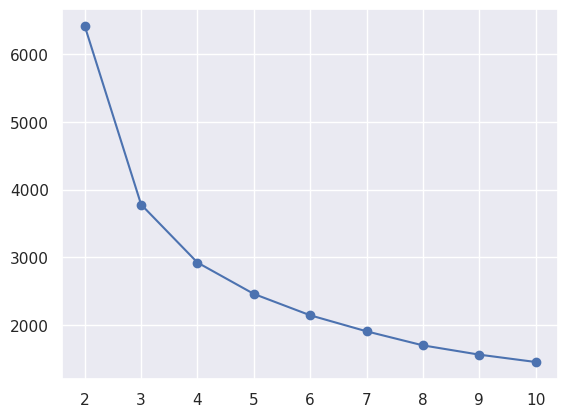

In [78]:
plt.plot(k_clusters, inertias.values(), '-o')
plt.show()

Based on the Inertia plot, the knee point is most likely at n_clusters = 3 or 4.\
To further help in deciding the optimal n_clusters, the following silhouette analysis will focus on n_clusters = 2 to 5. 

**Silhouette Plot**

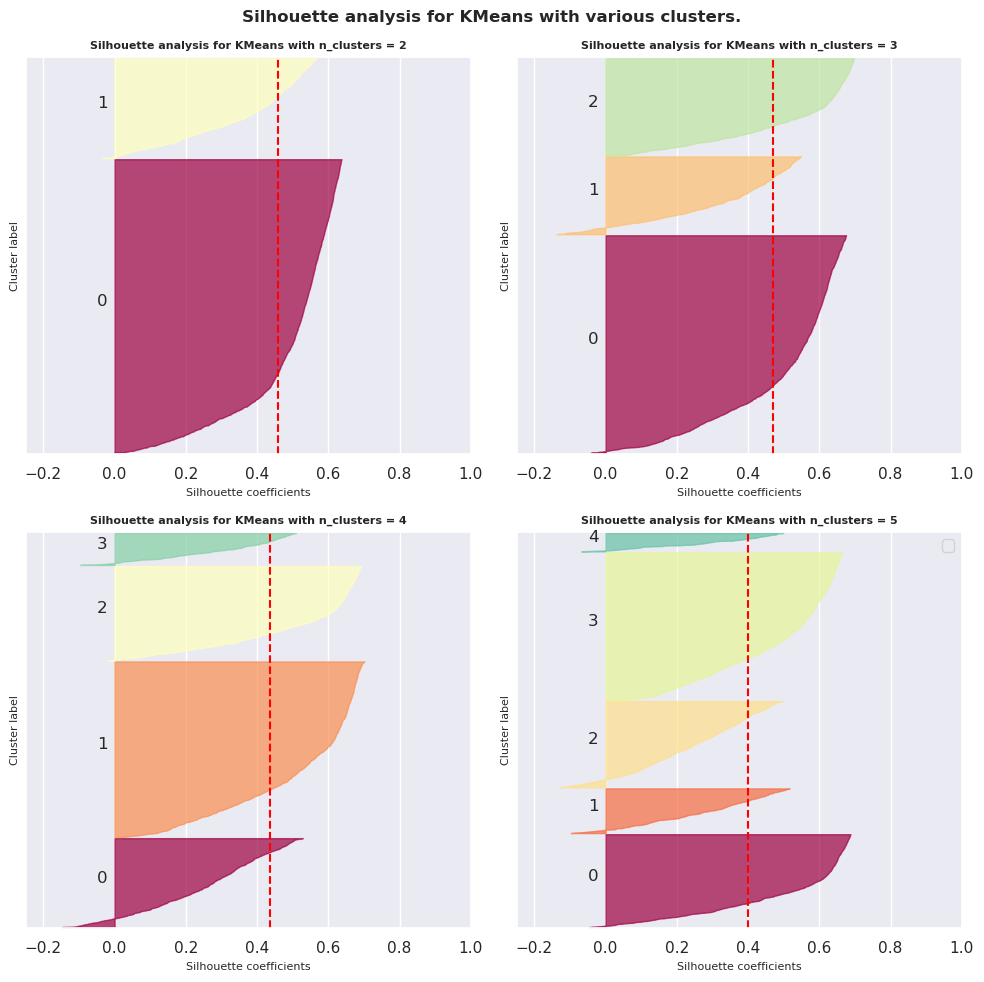

In [79]:
fig, ax1 = plt.subplots(2,2, figsize=(10,10))
avg_silhouette_scores = []
avg_per_k = {}

for i, k in enumerate(k_clusters[0:4]):

    xctr = yctr = 0
    if i%2 != 0:
        yctr = 1
    if i>=2:
        xctr = 1
    
    # The silhouette coefficient can range from -1, 1 
    ax1[xctr][yctr].set_xlim([-0.25, 1])
    ax1[xctr][yctr].set_ylim([-1, len(X_scaled) + (k + 1) * 10])

    np.random.seed(random_seed)
    np.random.default_rng(random_seed)
    clusterer = KMeans(n_clusters=k, 
                       random_state=random_seed, 
                       n_init = final_best_params['n_init'],
                       max_iter=final_best_params['max_iter'], 
                       init = final_best_params['init'],
                       tol = final_best_params['tol'],
                       algorithm = final_best_params['algorithm'])
    
    cl_labels = clusterer.fit_predict(X_scaled)

  
    silhouette_avg  = silhouette_score(X_scaled, cl_labels)
    avg_silhouette_scores.append(silhouette_avg)
    avg_per_k[k] = silhouette_avg
    
    sample_silhouette_values = silhouette_samples(X_scaled, cl_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cl_labels == i]

        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = colormaps.get_cmap('Spectral')
        color = cmap(float(i) / k)
        ax1[xctr][yctr].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1[xctr][yctr].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

   
    ax1[xctr][yctr].set_title("Silhouette analysis for KMeans with n_clusters = %d" % k, fontsize=8, fontweight='bold')
    ax1[xctr][yctr].set_xlabel("Silhouette coefficients", fontsize=8)
    ax1[xctr][yctr].set_ylabel("Cluster label",  fontsize=8)


    ax1[xctr][yctr].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1[xctr][yctr].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[xctr][yctr].set_xticks([ -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.legend()
    plt.tight_layout()
    plt.suptitle("Silhouette analysis for KMeans with various clusters.",
                 fontsize=12, fontweight='bold')

    

Between n_clusters=3 and n_clusters=4, the former has lower negative silhouette coefficient values, and the cluster label heights is even better compared to the latter.\
The optimal number of clusters for this dataset using KMeans algorithm is 3. 


**Create a new column, Cluster**

In [80]:
df_clustered = df.copy(deep=True)
df_clustered['Cluster'] = cluster_labels[3]
df_clustered['Cluster'].value_counts()

Cluster
0    2116
2     944
1     757
Name: count, dtype: int64

## 6 Customer Segmentation Analysis

### 6.1 Clusters' color designation

In [81]:
km_colors = { 0: '#fd4848',  #red
                1: '#69c641',  #green          
                2: '#4196c6',  #blue 
                3: '#fda848',  #orange
                }

km_colormap =  df_clustered['Cluster'].map(km_colors) 

### 6.2 Clusters 3D Plot

3D Plot for 3-Cluster Data

Text(0.5, 0, 'Monetary')

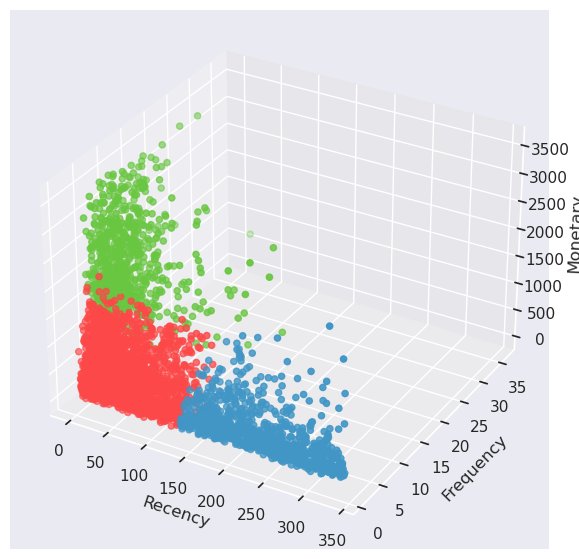

In [82]:
sns.set_style ("darkgrid")

fig = plt.figure (figsize=(14,7))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_clustered.Recency,
    df_clustered.Frequency, 
    df_clustered.Monetary,
    c=km_colormap,
    marker='o')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

### 6.3 Cluster Distribution

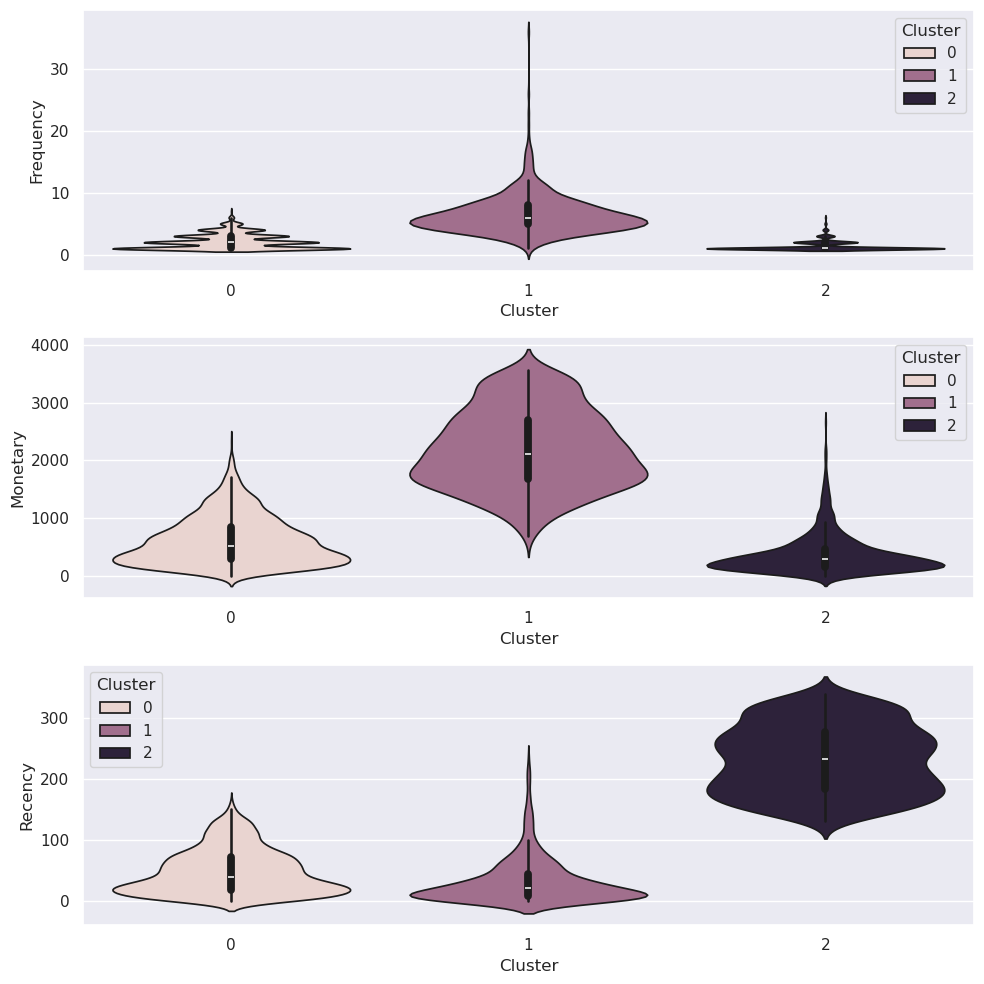

In [83]:
rfm_cols = df_clustered.columns.to_list()
rfm_cols.remove('Cluster')
rfm_cols

plt.figure(figsize=(10,10))

for idx, col in enumerate(rfm_cols):

    plt.subplot(3, 1, idx+1)
    sns.violinplot(x=df_clustered['Cluster'], y=df_clustered[col], hue=df_clustered['Cluster']) #palette=km_colors

plt.tight_layout()

## 6.4 Cluster Analysis


Cluster 1: <b>Moderate</b>

- Moderately frequent buyers that are not necessarily high spenders, and haven't purchased recently. 


Cluster 2: <b>Loyal</b>

- Frequent shoppers who are high spenders, although no recent purchases.


Cluster 0: <b>Recent</b>


- Less frequent buyers who are low-spenders but made recent purchases.


In [84]:
df_clustered['Cluster'].value_counts()

Cluster
0    2116
2     944
1     757
Name: count, dtype: int64

Map the assigned customer segment label to the cluster numbers in the dataset

In [85]:
cluster_mapping = {
    0: 'Moderate', 
    1: 'Loyal',
    2: 'Recent'
}

df_clustered['Cluster'] = df_clustered.Cluster.map(cluster_mapping)
df_clustered.Cluster.value_counts()

Cluster
Moderate    2116
Recent       944
Loyal        757
Name: count, dtype: int64

In [86]:
df_clustered.head()

,Frequency,Monetary,Recency,Cluster
CustomerID,,,,
12348,3,904.44,75,Moderate
12349,1,1757.55,18,Moderate
12350,1,334.40,310,Recent
12352,8,2506.04,36,Loyal
12353,1,89.00,204,Recent


# 7 Outliers Analysis

## 7.1 Assigning Cluster Labels

Before analyzing the outliers, assign cluster labels to the customers that were previously assigned clusters.

In [87]:
df_m_outliers.shape[0], df_f_outliers.shape[0]

(402, 412)

For now, outliers will be designated as follows:
>  - Monetary outliers : High-Spenders Customers
>  - Frequency outliers : Frequent Customers
>  - Both Monetary and Frequency outliers : VIPs 

In [88]:
df_vips = df_m_outliers.reset_index().merge(df_f_outliers, how='inner').set_index('index')
df_high_spenders = df_m_outliers.drop(df_vips.index)
df_frequent = df_f_outliers.drop(df_vips.index)

In [89]:
df_vips.drop('LastPurchaseDate', axis=1, inplace=True)
df_vips.set_index('CustomerID', inplace=True)
df_vips['Cluster'] = 'VIPs'
    
df_vips

,Frequency,Monetary,Recency,Cluster
CustomerID,,,,
12362,10,5226.23,3,VIPs
12415,21,124914.53,24,VIPs
12428,9,7956.46,25,VIPs
12431,13,5713.50,35,VIPs
12437,18,4951.41,1,VIPs
...,...,...,...,...
18198,17,5425.56,4,VIPs
18223,13,5982.85,4,VIPs
18225,11,5474.96,3,VIPs


In [90]:
df_high_spenders.drop('LastPurchaseDate', axis=1, inplace=True)
df_high_spenders.set_index('CustomerID', inplace=True)
df_high_spenders['Cluster'] = 'High Spenders'
df_high_spenders

,Frequency,Monetary,Recency,Cluster
CustomerID,,,,
12346,1,77183.60,325,High Spenders
12347,6,3598.21,2,High Spenders
12357,1,6207.67,33,High Spenders
12359,4,6310.03,57,High Spenders
12378,1,4008.62,129,High Spenders
...,...,...,...,...
18079,4,3613.15,45,High Spenders
18087,2,4055.72,98,High Spenders
18092,8,6215.62,2,High Spenders


In [91]:
df_frequent.drop('LastPurchaseDate', axis=1, inplace=True)
df_frequent.set_index('CustomerID', inplace=True)
df_frequent['Cluster'] = 'Frequent'
df_frequent

,Frequency,Monetary,Recency,Cluster
CustomerID,,,,
12395,10,2338.71,19,Frequent
12523,11,1789.77,19,Frequent
12584,9,2338.15,3,Frequent
12594,10,3338.22,37,Frequent
12708,9,2516.47,29,Frequent
...,...,...,...,...
18075,9,2412.80,23,Frequent
18077,9,2188.08,8,Frequent
18144,10,2386.10,7,Frequent


## 7.2 Combining data

In [92]:
df_all = pd.concat([df_clustered, df_vips, df_high_spenders, df_frequent])
df_all.head()

,Frequency,Monetary,Recency,Cluster
CustomerID,,,,
12348,3,904.44,75,Moderate
12349,1,1757.55,18,Moderate
12350,1,334.40,310,Recent
12352,8,2506.04,36,Loyal
12353,1,89.00,204,Recent


# 8 Visualizing Customer Segmentation

In [93]:
df_groupings = pd.DataFrame(df_all.Cluster.value_counts())
df_groupings.reset_index(inplace=True)

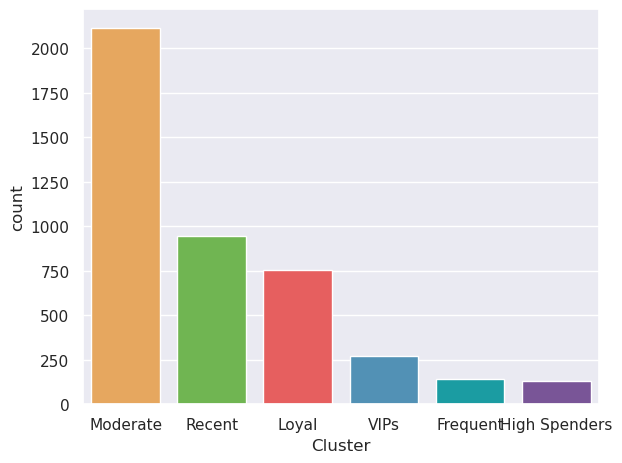

In [94]:
palette = {
                'Recent' : '#69c641',    
                'Moderate': '#fda848',   
                'Loyal':  '#fd4848' ,  
                'VIPs':   '#4196c6',
                'Frequent': '#04b1b9',      
                'High Spenders': '#7a4aa2'       
}


sns.barplot( data=df_groupings, x='Cluster', y='count', palette = palette)
plt.tight_layout()
plt.show()

# 9 Customer Segmentation Analysis and Recommendations

<font color='#fda848'><b>Moderate</b></font>

- Moderately frequent buyers that are not necessarily high spenders, and haven't purchased recently. 

Recommendation: 
1. Offer subscription on frequently bought items (whenever applicable)
2. Recommend "Frequently bought together" items
3. Implement customer retention and loyalty programs

<font color='#69c641'><b>Recent</b></font>


- Less frequent buyers who are low-spenders but made recent purchases.

Recommendations:
1. Identify recently purhcased products and run targeted "similar products" ad recommendations
2. Encourage to purchase more by offering incentives, vouchers, discounts, and bundle deals. 
3. Enhance customer experience and services

<font color='#fd4848'><b>Loyal</b></font>

- Frequent shoppers who are high spenders, although no recent purchases.

Recommendations:
1. Re-engage by implementing rewards and loyalty programs, and exclusive perks
2. Run targeted ads for trending items and top items sold 
3. Offer subscription on frequently bought items (whenever applicable)

<font color='#4196c6'><b>VIPs</b></font>

- High value, frequent buyers. 

Recommendations:
1. Offer exclusive perks, and vouchers
2. Pamper and enhance shopping experience by offering expedited or free shipping (whenever applicable)

<font color='#04b1b9'><b>Frequent</b></font>

- Very frequent buyers. 

Recommendations:
1. Offer subscription on frequently bought items (whenever applicable)
2. Implement customer retention and loyalty programs
3. Offer expedited or free shipping vouchers (whenever applicable)

<font color='#7a4aa2'><b>High Spenders</b></font>

- High-spending buyers.

Recommendation: 
1. Implement customer retention and loyalty programs
2. Offer discounts on bulk purchases or reaching certain amount (whenever applicable)
3. Enhance customer experience and services